<a href="https://colab.research.google.com/github/junweiluo/HandsonMLPractice/blob/master/Chapter17Ex04_Recurrent_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Autoencoder*: 
1. unsupervised pretraining with few labeled data
2. dimensionality reduction

AE for sequences, time series or texts (unsupervised learning or dimensionality reduction)

However, this case is still for image processing to show how RNN works.

Encoder - Seq2Vec
Decoder - Vec2Seq

Using RepeatVector() layer as the first layer of decoder.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:        
      plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [0]:
recurrent_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 28, 100)           51600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [0]:
recurrent_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_1 (RepeatVecto (None, 28, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 28, 100)           52400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 28)            2828      
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [0]:
recurrent_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30)                67320     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [0]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3970 - rounded_accuracy: 0.8471 - val_loss: 0.3759 - val_rounded_accuracy: 0.8662
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3639 - rounded_accuracy: 0.8728 - val_loss: 0.3584 - val_rounded_accuracy: 0.8745
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3517 - rounded_accuracy: 0.8813 - val_loss: 0.3506 - val_rounded_accuracy: 0.8823
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3418 - rounded_accuracy: 0.8868 - val_loss: 0.3453 - val_rounded_accuracy: 0.8868
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3337 - rounded_accuracy: 0.8926 - val_loss: 0.3341 - val_rounded_accuracy: 0.8895
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3281 - rounded_accuracy: 0.8964 - val_loss: 0.3263 - val_rounded_accuracy: 0.8965
Epoch 7/10
1719/1719 [============

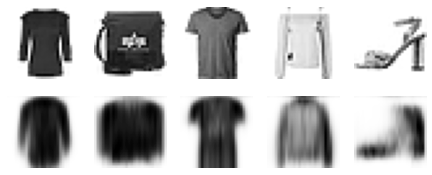

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(recurrent_ae)
plt.show()